# DATA Structure 
data/<br>
test_black: 3740 items (0.jpg -3000.jpg + image5000.jpg-image5738.jpg)<br>
test_color: 3740 items (0.jpg -3000.jpg + image5000.jpg-image5738.jpg)<br>
train_black:9128 items (3001.jpg -7128.jpg + image0000.jpg-image4999jpg)<br>
train_color: 9128 items (3001.jpg -7128.jpg + image0000.jpg-image4999jpg)<br>

#### Organize Dataset Loader in Jupyter

In [6]:
import sys
print(sys.executable)



d:\1_Charvi\Installations\Anaconda3\envs\mycvenv\python.exe


In [7]:
# !pip install pillow torchvision torch matplotlib


In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class ColorizationDataset(Dataset):
    def __init__(self, black_dir, color_dir, transform_input=None, transform_target=None):
        self.black_dir = black_dir
        self.color_dir = color_dir
        self.black_images = sorted(os.listdir(black_dir))
        self.color_images = sorted(os.listdir(color_dir))
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.black_images)

    def __getitem__(self, idx):
        black_path = os.path.join(self.black_dir, self.black_images[idx])
        color_path = os.path.join(self.color_dir, self.color_images[idx])

        black_image = Image.open(black_path).convert("L")  # Grayscale
        color_image = Image.open(color_path).convert("RGB")  # Color

        if self.transform_input:
            black_image = self.transform_input(black_image)
        if self.transform_target:
            color_image = self.transform_target(color_image)

        return black_image, color_image


In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform_input = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# transform_target = transforms.Compose([
#  transforms.Resize((256, 256)),
#     transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     # Normalize RGB to [-1, 1]
# ])
transform_target = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Optional
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


train_dataset = ColorizationDataset(
    black_dir='data/train_black',
    color_dir='data/train_color',
    transform_input=transform_input,
    transform_target=transform_target
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


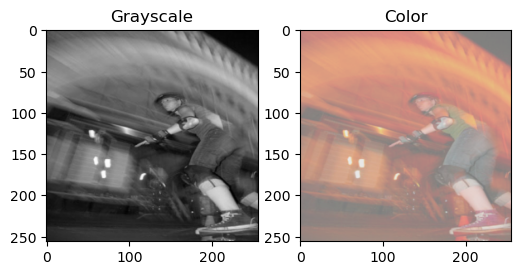

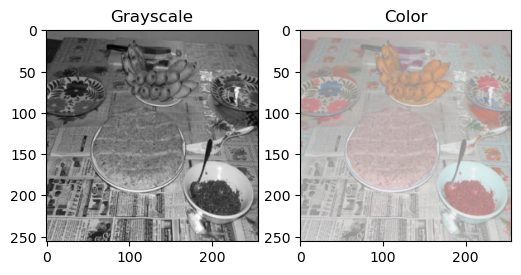

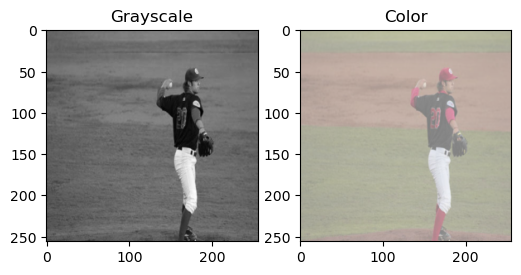

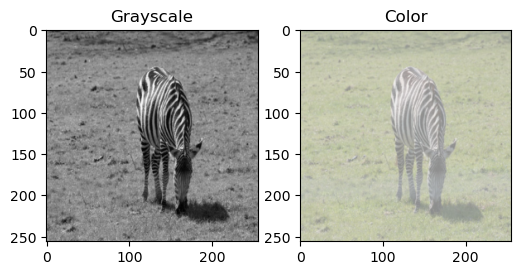

In [10]:
import matplotlib.pyplot as plt
import torch

def unnormalize(tensor):
    return torch.clamp((tensor * 0.5) + 0.5, 0, 1)


def show_sample(batch):
    gray, color = batch
    for i in range(4):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(gray[i][0], cmap='gray')
        axs[0].set_title("Grayscale")
        # axs[1].imshow(color[i].permute(1, 2, 0))
        axs[1].imshow(unnormalize(color[i]).permute(1, 2, 0))
        axs[1].set_title("Color")
        plt.show()

sample_batch = next(iter(train_loader))
show_sample(sample_batch)


We'll use a U-Net architecture

In [11]:
import torch
import torch.nn as nn

class UNetColorization(nn.Module):
    def __init__(self):
        super(UNetColorization, self).__init__()
        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

        def up(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

        self.encoder = nn.Sequential(
            down(1, 64),
            down(64, 128),
            down(128, 256),
            down(256, 512),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 512, 3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            up(512, 256),
            up(256, 128),
            up(128, 64),
            up(64, 32),
        )

        self.final = nn.Conv2d(32, 3, 1)  # Output 3-channel RGB

    def forward(self, x):
        enc = self.encoder(x)
        x = self.middle(enc)
        x = self.decoder(x)
        x = self.final(x)
        return torch.tanh(x)  # Output in range [-1, 1]


In [12]:
# %pip install tqdm


In [17]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print(f"CUDA Version: {cuda_version}")

    # Get the GPU device name
    device_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {device_name}")
else:
    print("CUDA is not available.")


CUDA Available: True
CUDA Version: 11.8
GPU Name: NVIDIA GeForce GTX 1650


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your model (ensure you have UNetColorization defined elsewhere)
model = UNetColorization().to(device)

# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate through the dataset
    for gray, color in tqdm(train_loader):  # tqdm for progress bar
        gray, color = gray.to(device), color.to(device)  # Move data to GPU

        # Forward pass
        output = model(gray)

        # Compute loss
        loss = criterion(output, color)

        # Backpropagation and optimization
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update parameters

        running_loss += loss.item()  # Accumulate loss

    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Save the trained model after the final epoch
model_save_path = "unet_colorization_model.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


100%|██████████| 286/286 [07:55<00:00,  1.66s/it]


Epoch [1/30], Loss: 0.2311


100%|██████████| 286/286 [06:33<00:00,  1.37s/it]


Epoch [2/30], Loss: 0.1968


100%|██████████| 286/286 [06:15<00:00,  1.31s/it]


Epoch [3/30], Loss: 0.1900


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [4/30], Loss: 0.1844


100%|██████████| 286/286 [06:27<00:00,  1.35s/it]


Epoch [5/30], Loss: 0.1819


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [6/30], Loss: 0.1798


100%|██████████| 286/286 [06:29<00:00,  1.36s/it]


Epoch [7/30], Loss: 0.1781


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [8/30], Loss: 0.1768


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [9/30], Loss: 0.1760


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [10/30], Loss: 0.1744


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [11/30], Loss: 0.1724


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [12/30], Loss: 0.1720


100%|██████████| 286/286 [06:25<00:00,  1.35s/it]


Epoch [13/30], Loss: 0.1700


100%|██████████| 286/286 [06:25<00:00,  1.35s/it]


Epoch [14/30], Loss: 0.1696


100%|██████████| 286/286 [06:27<00:00,  1.35s/it]


Epoch [15/30], Loss: 0.1691


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [16/30], Loss: 0.1688


100%|██████████| 286/286 [06:30<00:00,  1.36s/it]


Epoch [17/30], Loss: 0.1676


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [18/30], Loss: 0.1676


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [19/30], Loss: 0.1677


100%|██████████| 286/286 [06:27<00:00,  1.36s/it]


Epoch [20/30], Loss: 0.1657


100%|██████████| 286/286 [06:27<00:00,  1.35s/it]


Epoch [21/30], Loss: 0.1646


100%|██████████| 286/286 [06:27<00:00,  1.35s/it]


Epoch [22/30], Loss: 0.1638


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [23/30], Loss: 0.1644


100%|██████████| 286/286 [06:27<00:00,  1.35s/it]


Epoch [24/30], Loss: 0.1639


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [25/30], Loss: 0.1623


100%|██████████| 286/286 [06:27<00:00,  1.36s/it]


Epoch [26/30], Loss: 0.1612


100%|██████████| 286/286 [06:26<00:00,  1.35s/it]


Epoch [27/30], Loss: 0.1613


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [28/30], Loss: 0.1599


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]


Epoch [29/30], Loss: 0.1594


100%|██████████| 286/286 [06:28<00:00,  1.36s/it]

Epoch [30/30], Loss: 0.1591
Model saved to unet_colorization_model.pth


In [19]:
import torch

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = UNetColorization().to(device)
model.load_state_dict(torch.load("unet_colorization_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode


C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_11040\994305978.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_colorizati

UNetColorization(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (middle): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=

In [20]:
# torch.save(model.state_dict(), "colorization_unet.pth")
# Load the model
model = UNetColorization().to(device)
model.load_state_dict(torch.load("unet_colorization_model.pth"))
model.eval()  # Set the model to evaluation mode for inference


C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_11040\548370337.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_colorizati

UNetColorization(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (middle): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=

C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_11040\2027165642.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_coloriza

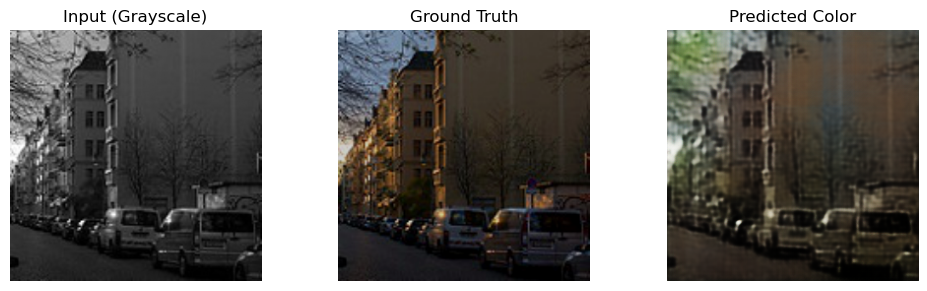

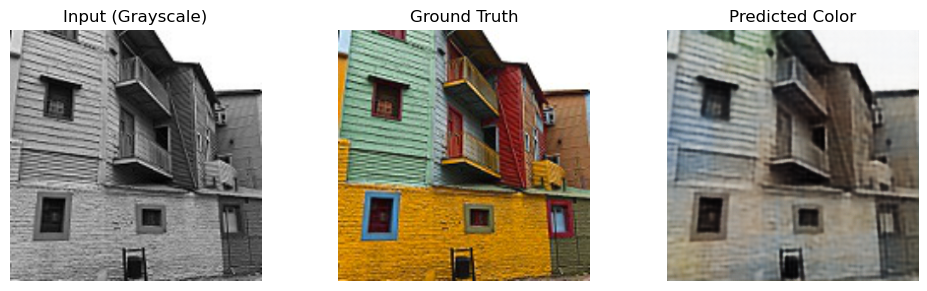

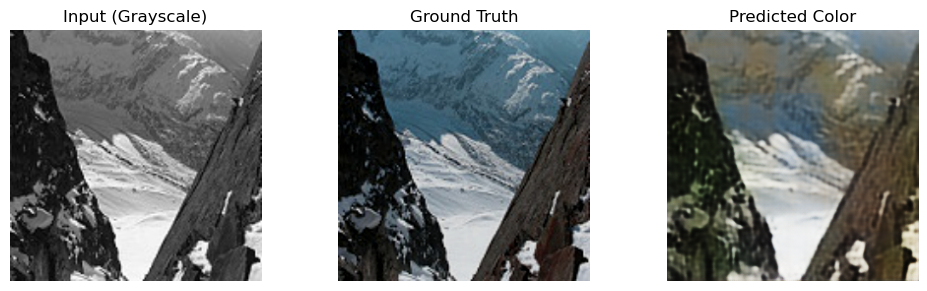

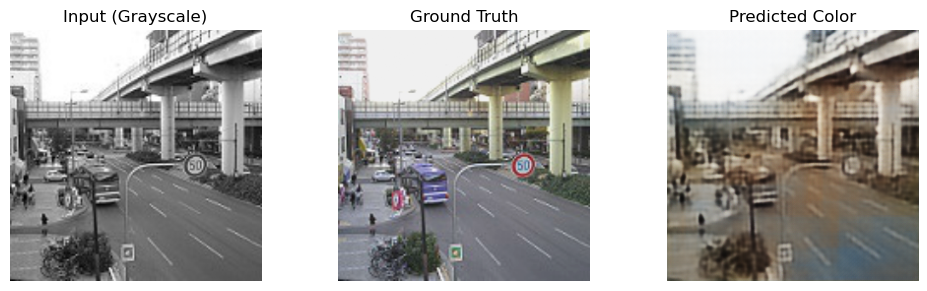

In [21]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Load test dataset
test_dataset = ColorizationDataset(
    black_dir='data/test_black',
    color_dir='data/test_color',  # We'll use this just for visual comparison
    transform_input=transform_input,
    transform_target=transform_target
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load the model
model = UNetColorization().to(device)
model.load_state_dict(torch.load("unet_colorization_model.pth", map_location=device))
model.eval()

# Visualize output
def visualize_results(model, dataloader):
    gray_batch, color_batch = next(iter(dataloader))
    gray_batch = gray_batch.to(device)

    with torch.no_grad():
        output_batch = model(gray_batch)
        output_batch = (output_batch + 1) / 2  # [-1, 1] → [0, 1]
        output_batch = torch.clamp(output_batch, 0, 1)

    for i in range(gray_batch.size(0)):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

        # Grayscale Input
        axs[0].imshow(gray_batch[i][0].cpu(), cmap='gray')
        axs[0].set_title("Input (Grayscale)")
        axs[0].axis('off')

        # Ground Truth Color
        axs[1].imshow(color_batch[i].permute(1, 2, 0).cpu())
        # axs[1].imshow(unnormalize(color_batch[i]).permute(1, 2, 0).cpu())
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        # Model Output
        axs[2].imshow(output_batch[i].permute(1, 2, 0).cpu())
        axs[2].set_title("Predicted Color")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

visualize_results(model, test_loader)


In [23]:
num_epochs = 100


In [24]:
# --- Generator: U-Net Based ---
class GeneratorUNet(nn.Module):
    def __init__(self):
        super(GeneratorUNet, self).__init__()

        def down(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up(in_channels, out_channels, dropout=0.0):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down(1, 64, normalize=False)
        self.down2 = down(64, 128)
        self.down3 = down(128, 256)
        self.down4 = down(256, 512)

        self.middle = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = up(512, 256)
        self.up2 = up(256, 128)
        self.up3 = up(128, 64)
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        m = self.middle(d4)

        u1 = self.up1(m)
        u2 = self.up2(u1)
        u3 = self.up3(u2)
        output = self.up4(u3)
        return output


In [25]:
# --- Discriminator: PatchGAN ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, gray, color):
        # Concatenate grayscale and color images as channels
        x = torch.cat([gray, color], dim=1)
        return self.model(x)


In [29]:
import torch
import torch.nn as nn
from tqdm import tqdm

generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=100, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=100, gamma=0.5)


for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0

    for gray, color in tqdm(train_loader):
        gray, color = gray.to(device), color.to(device)

        # Get dynamic shape for the patch (output of discriminator)
        with torch.no_grad():
            patch_shape = discriminator(gray, color).shape

        valid = torch.ones(patch_shape, device=device).uniform_(0.9, 1.0)
        fake = torch.zeros(patch_shape, device=device).uniform_(0.0, 0.1)
        # valid = torch.ones(patch_shape, device=device)
        # fake = torch.zeros(patch_shape, device=device)
        

        # === Train Generator ===
        optimizer_G.zero_grad()
        fake_color = generator(gray)

        pred_fake = discriminator(gray, fake_color)
        g_adv_loss = adversarial_loss(pred_fake, valid)
        g_l1 = l1_loss(fake_color, color)
        g_loss = g_adv_loss + 10 * g_l1  # Weighted sum

        g_loss.backward()
        optimizer_G.step()

        # === Train Discriminator ===
        optimizer_D.zero_grad()

        pred_real = discriminator(gray, color)
        real_loss = adversarial_loss(pred_real, valid)

        pred_fake = discriminator(gray, fake_color.detach())
        fake_loss = adversarial_loss(pred_fake, fake)

        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}]  G Loss: {epoch_g_loss / len(train_loader):.4f}  D Loss: {epoch_d_loss / len(train_loader):.4f}")

    scheduler_G.step()
    scheduler_D.step()


# Save final generator model
torch.save(generator.state_dict(), "generator_pix2pix.pth")


  1%|          | 3/286 [00:07<11:44,  2.49s/it]


KeyboardInterrupt: 

In [60]:
model = UNetColorization().to(device)
model.load_state_dict(torch.load("unet_colorization_model.pth", map_location=device))


C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_11040\3971129877.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_colorizat

<All keys matched successfully>

In [61]:
# generator = GeneratorUNet().to(device)
# generator.load_state_dict(torch.load("generator_pix2pix.pth", map_location=device))
# torch.save(discriminator.state_dict(), "discriminator_pix2pix.pth")

# # Convert from [-1, 1] to [0, 1]
# fake_color = (fake_color + 1) / 2


In [64]:
# Load the trained generator model
generator = GeneratorUNet().to(device)
generator.load_state_dict(torch.load("generator_pix2pix.pth", map_location=device))
generator.eval()


C:\Users\Jishnu Nallareddy\AppData\Local\Temp\ipykernel_11040\2135975361.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_

GeneratorUNet(
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (middle): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddin

In [67]:
from torchvision.transforms.functional import to_pil_image
from PIL import ImageEnhance
import matplotlib.pyplot as plt

# def enhance_output(tensor_img):
#     pil_img = to_pil_image(tensor_img.cpu().clamp(0, 1))  # Clamp for safety
#     brightness = ImageEnhance.Brightness(pil_img).enhance(1.3)
#     contrast = ImageEnhance.Contrast(brightness).enhance(1.2)
#     return contrast
def enhance_output(tensor_img):
    from torchvision.transforms.functional import to_pil_image
    from PIL import ImageEnhance

    # Convert to PIL and clamp to [0, 1]
    pil_img = to_pil_image(tensor_img.cpu().clamp(0, 1))

    # Mild enhancement to avoid white facade
    brightness = ImageEnhance.Brightness(pil_img).enhance(1.1)  # reduced from 1.3
    contrast = ImageEnhance.Contrast(brightness).enhance(1.15)

    # Slight saturation boost to fight dullness
    try:
        saturation = ImageEnhance.Color(contrast).enhance(1.3)
    except:
        saturation = contrast  # fallback if grayscale

    return saturation


def visualize_generator_output(generator, dataloader, device="cuda"):
    generator.eval()
    with torch.no_grad():
        gray_batch, color_batch = next(iter(dataloader))
        gray_batch = gray_batch.to(device)

        # Forward pass
        fake_color_batch = generator(gray_batch)
        fake_color_batch = (fake_color_batch + 1) / 2.0  # If tanh used; else skip this
        fake_color_batch = torch.clamp(fake_color_batch, 0, 1)

        for i in range(min(4, gray_batch.size(0))):
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))

            # Input Grayscale
            axs[0].imshow(gray_batch[i][0].cpu(), cmap='gray')
            axs[0].set_title("Input (Grayscale)")
            axs[0].axis('off')

            # Ground Truth Color
            axs[1].imshow(color_batch[i].permute(1, 2, 0).cpu())
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            # Generated Color Output
            enhanced = enhance_output(fake_color_batch[i])
            axs[2].imshow(enhanced)
            axs[2].set_title("Generated (Enhanced)")
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()


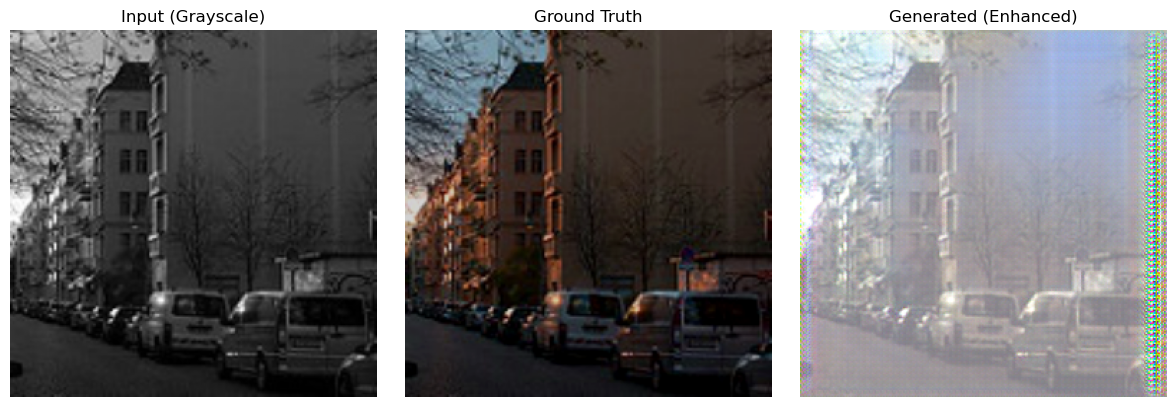

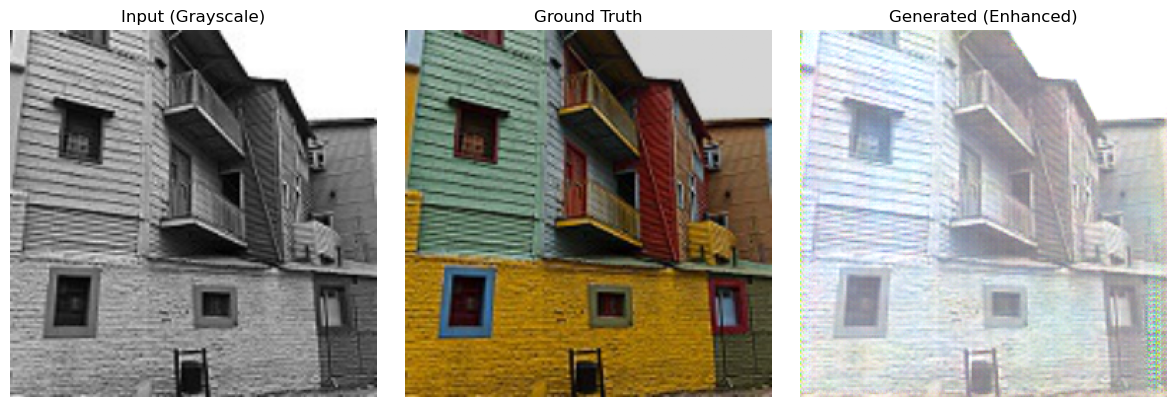

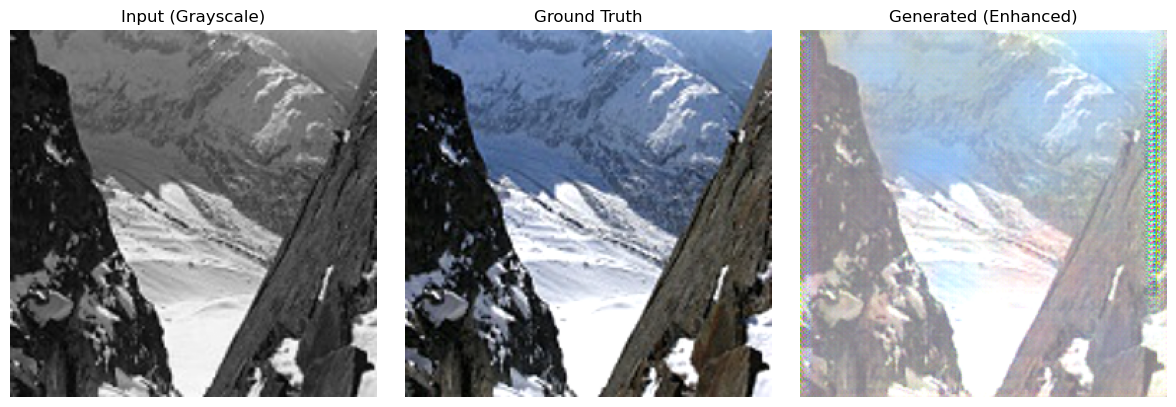

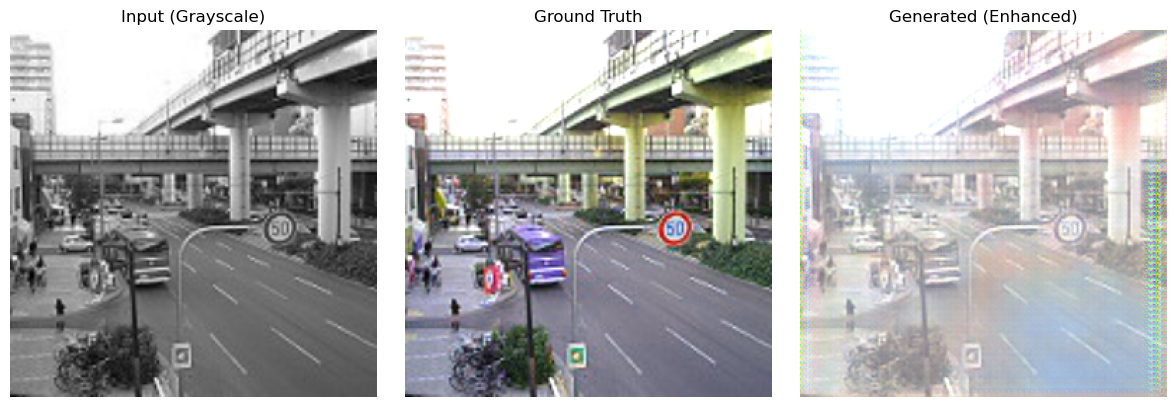

In [68]:
visualize_generator_output(generator, test_loader)
